# Main 

## Check Setup

In [1]:
from helpers_functions.setup import *

path_archive = "archive"

path_train_val_list = "archive/train_val_list_NIH.txt"
path_test_list = "archive/test_list_NIH.txt"

path_all_data_csv = "archive/Data_Entry_2017.csv"

path_folder_images = "archive/images-224/images-224"

### Check structure

In [2]:
import json

path = path_archive
print(json.dumps(list_tree(path, max_depth=1), indent=2))


{
  "_files": [
    "BBox_List_2017_Official_NIH.csv",
    "test_list_NIH.txt",
    ".DS_Store",
    "pretrained_model.h5",
    "train_val_list_NIH.txt",
    "Data_Entry_2017.csv"
  ],
  "images-224": {
    "_files": [
      ".DS_Store"
    ],
    "images-224": "..."
  }
}


## Data Preprocessing

### Create class-label linking

In [3]:
from helpers_functions.multi_hot import *

class_label_str_to_idx, class_label_idx_to_str = create_class_mappings(path_all_data_csv)

print(class_label_str_to_idx)
print(class_label_idx_to_str)

{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}
{0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Consolidation', 3: 'Edema', 4: 'Effusion', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Hernia', 8: 'Infiltration', 9: 'Mass', 10: 'No Finding', 11: 'Nodule', 12: 'Pleural_Thickening', 13: 'Pneumonia', 14: 'Pneumothorax'}


### Multi-hot encoding

In [4]:
# Assume class_to_idx and idx_to_class are already created
image_to_multihot = create_image_multihot_mapping_from_dicts(path_all_data_csv, class_label_str_to_idx)

# Check the first image mapping
first_image = list(image_to_multihot.keys())[0]
print(first_image, image_to_multihot[first_image])


00000001_000.png [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Modeling

#### Make a Dataloader

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 15])
First image name: 00004959_004.png
First label vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


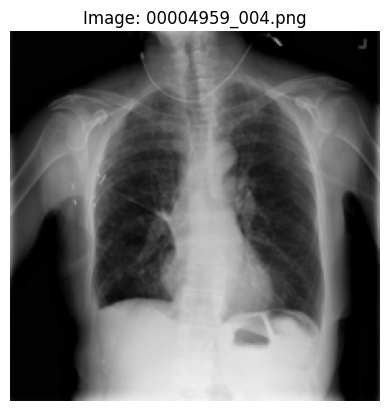

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class MedicalImageDataset(Dataset):
    """
    PyTorch Dataset for medical images with precomputed multi-hot labels.

    Each sample returns:
        - image tensor
        - multi-hot label vector
        - image file name
    """
    def __init__(self, files_list_dir: str, img_dir: str, image_to_multihot: dict, transform=None):
        """
        Args:
            files_list_dir (str): Path to a .txt file with each row being an image name.
            img_dir (str): Directory containing the images.
            image_to_multihot (dict): Precomputed dictionary mapping image name → multi-hot vector.
            transform (callable, optional): Optional transform to apply to images.
        """
        # Load image names from txt
        with open(files_list_dir, "r") as f:
            self.image_names = [line.strip() for line in f if line.strip()]

        self.img_dir = img_dir
        self.image_to_multihot = image_to_multihot
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Ensure no infinite loop
        if idx >= 2 * len(self):
            raise FileNotFoundError(f"No valid images.")

        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Skip missing images
        if not os.path.exists(img_path):
            print(f"Warning: Image file '{img_path}' not found. Skipping to next index.")
            return self.__getitem__((idx + 1) % len(self))  # wrap around if at end


        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            # Default conversion to tensor
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float() / 255.0

        # Get multi-hot vector from precomputed dictionary
        multi_hot = torch.from_numpy(
            self.image_to_multihot.get(
                img_name,
                np.zeros(len(next(iter(self.image_to_multihot.values()))),
                dtype=np.float32)
            )
        )

        return image, multi_hot, img_name


# Create Dataset and DataLoader
dataset = MedicalImageDataset(path_train_val_list, path_folder_images, image_to_multihot)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get the first batch
imgs, multi_hot, names = next(iter(loader))

print("Image batch shape:", imgs.shape)
print("Label batch shape:", multi_hot.shape)
print("First image name:", names[0])
print("First label vector:", multi_hot[0])

# Display the first image in the batch
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title(f"Image: {names[0]}")
plt.axis('off')
plt.show()


#### Create CNN

In [10]:
from models.models import *

model_name = "Base"
model = models(model_name, backbone_name='resnet18')

print(model)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Train the CNN

In [ ]:
from models.train import *
from models.val import *
import torch
from torch.utils.data import random_split


from torch.utils.data import Subset

# Train Parameters
epochs = 10
val_every = 5
batch_size = 16
save = True
save_every = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Split the dataset into train and val
val_ratio = 0.2
total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size
torch.manual_seed(42) # Set seed for reproducibility

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# TODO: DELETE ONCE READY TO FULLY UTILIZE
# Take first 100 elements
#train_subset = Subset(train_dataset, indices=list(range(100)))
# Take first 100 elements
#val_subset = Subset(train_dataset, indices=list(range(100)))

# Train and time model
import time
start_time = time.perf_counter()
for epoch in range(0, epochs, val_every):
    train(
        model_name,
        model, 
        optimizer,
        train_dataset, start_epoch=epoch, end_epoch=min(epoch+val_every, epochs),
        batch_size=batch_size, device=device, 
        save=save, save_every=save_every, checkpoint_dir=f"checkpoints/{model_name}"
    )
    val(model_name, 
        model, 
        val_dataset, epoch=epoch+val_every, 
        batch_size=batch_size, device=device
    )
end_time = time.perf_counter()
elapsed_time = end_time - start_time

print(f"{epochs} Epochs model {model_name} train/val time: {elapsed_time:.4f} seconds")

Train dataset size: 69220
Validation dataset size: 17304


Epoch 1/5: 100%|██████████| 7/7 [00:58<00:00,  8.32s/batch, loss=0.13] 


Epoch 1/5 completed - Average Loss: 87.9250


Epoch 2/5: 100%|██████████| 7/7 [00:29<00:00,  4.19s/batch, loss=0.0608]


Epoch 2/5 completed - Average Loss: 47.8931


Epoch 3/5: 100%|██████████| 7/7 [00:30<00:00,  4.32s/batch, loss=0.222]


Epoch 3/5 completed - Average Loss: 43.2640


Epoch 4/5: 100%|██████████| 7/7 [00:35<00:00,  5.01s/batch, loss=0.349]


Epoch 4/5 completed - Average Loss: 40.8691


Epoch 5/5: 100%|██████████| 7/7 [00:33<00:00,  4.80s/batch, loss=0.157]


Epoch 5/5 completed - Average Loss: 38.3047


Validation Epoch 5: 100%|██████████| 7/7 [00:21<00:00,  3.07s/batch, loss=0.204]


Validation Epoch 5 completed - Average Loss: 59.8579


Epoch 6/10: 100%|██████████| 7/7 [00:30<00:00,  4.38s/batch, loss=0.228]


Epoch 6/10 completed - Average Loss: 38.3313


Epoch 7/10: 100%|██████████| 7/7 [00:28<00:00,  4.14s/batch, loss=0.228]


Epoch 7/10 completed - Average Loss: 36.3738


Epoch 8/10: 100%|██████████| 7/7 [00:24<00:00,  3.56s/batch, loss=0.215]


Epoch 8/10 completed - Average Loss: 34.8736


Epoch 9/10: 100%|██████████| 7/7 [00:28<00:00,  4.06s/batch, loss=0.0891]


Epoch 9/10 completed - Average Loss: 33.3191


Epoch 10/10: 100%|██████████| 7/7 [00:20<00:00,  2.90s/batch, loss=0.178]


Epoch 10/10 completed - Average Loss: 31.4283


Validation Epoch 10: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch, loss=0.0859]

Validation Epoch 10 completed - Average Loss: 29.7043
10 Epochs model Base train/val time: 349.5723 seconds


#### Classifier Performance

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 15])
First image name: 00003369_001.png
First label vector: tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


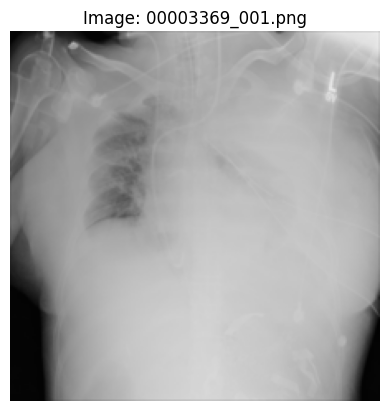

In [12]:
# Create Dataset and DataLoader
test_dataset = MedicalImageDataset(path_test_list, path_folder_images, image_to_multihot)

test_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get the first batch
imgs, multi_hot, names = next(iter(test_loader))

print("Image batch shape:", imgs.shape)
print("Label batch shape:", multi_hot.shape)
print("First image name:", names[0])
print("First label vector:", multi_hot[0])

# Display the first image in the batch
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title(f"Image: {names[0]}")
plt.axis('off')
plt.show()


In [ ]:
from helpers_functions.metrics import *
from models.pred import *

from torch.utils.data import Subset
from io import StringIO
import sys

# TODO: DELETE ONCE READY TO FULLY UTILIZE
# Take first 100 elements
#test_subset = Subset(test_dataset, indices=list(range(100)))

save_dir = f"results/{model_name}"
os.makedirs(save_dir, exist_ok=True)

#capture printed output
buffer = StringIO()
stdout_original = sys.stdout
sys.stdout = buffer  # redirect prints into buffer

df, cm = evaluate(
    model_name=model_name, 
    model=model,
    pred=pred, 
    dataset=test_dataset)

print(json.dumps(df.to_dict(), indent=2))

print("Confusion Matrix\n", cm)

# Restore stdout
sys.stdout = stdout_original

# Print to console normally
print(buffer.getvalue())

# Save captured text to file 
log_path = os.path.join(save_dir, "metrics_output.txt")
with open(log_path, "w") as f:
    f.write(buffer.getvalue())

print(f"\nSaved printed metrics to:\n  {log_path}")

{
  "metrics": {
    "general": {
      "AP": 0.18531696498394012,
      "AUROC": 0.5142950415611267,
      "F1-score": 0.030810365453362465
    },
    "class_wise": {
      "class_0": {
        "AP": 0.09780257195234299,
        "AUROC": 0.5698925256729126,
        "F1-score": 0.0
      },
      "class_1": {
        "AP": 0.2625032961368561,
        "AUROC": 0.544407844543457,
        "F1-score": 0.0
      },
      "class_2": {
        "AP": 0.1241629347205162,
        "AUROC": 0.6850998997688293,
        "F1-score": 0.0
      },
      "class_3": {
        "AP": 0.2796087861061096,
        "AUROC": 0.47843137383461,
        "F1-score": 0.0
      },
      "class_4": {
        "AP": 0.4172161817550659,
        "AUROC": 0.6718639135360718,
        "F1-score": 0.0
      },
      "class_5": {
        "AP": 0.2594139575958252,
        "AUROC": 0.5260416865348816,
        "F1-score": 0.0
      },
      "class_6": {
        "AP": -0.0,
        "AUROC": 0.0,
        "F1-score": 0.0
      },
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


# Prediction

## Threshold Tuning

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from torch.utils.data import DataLoader

print("Device:", device)

# path to the checkpoint
path_checkpoint = "checkpoints/ASL/ASL_epoch005 - best.pth"
out_dir = f"results/{model_name}"
os.makedirs(out_dir, exist_ok=True)

try:
    val_dataset  
except NameError:
    raise RuntimeError("val_dataset not found in notebook.")

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Robust load (reuse your load function or quick loader)
def load_checkpoint_to_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict):
        for key in ("model_state_dict", "state_dict", "model", "net"):
            if key in ckpt:
                state = ckpt[key]; break
        else:
            state = ckpt
    else:
        state = ckpt

    new_state = {}
    for k, v in state.items():
        nk = k[len("module."):] if k.startswith("module.") else k
        new_state[nk] = v
    model.load_state_dict(new_state, strict=False)
    model.to(device)
    model.eval()
    return model

# Robust extraction of logits from model output
def extract_logits(output):
    """
    Return a torch.Tensor of logits.
    Handles:
      - tensor -> return it
      - tuple/list -> take first element (if tensor)
      - dict -> try common keys ('logits','out','pred','prediction')
    """
    # direct tensor
    if torch.is_tensor(output):
        return output
    # tuple or list
    if isinstance(output, (tuple, list)):
        if len(output) == 0:
            raise ValueError("Model returned empty tuple/list")
        return extract_logits(output[0])
    # dict-like
    if isinstance(output, dict):
        for key in ("logits", "out", "pred", "prediction", "score"):
            if key in output:
                return extract_logits(output[key])
        # otherwise try to find the first tensor value
        for v in output.values():
            if torch.is_tensor(v):
                return v
    raise TypeError(f"Cannot extract logits from model output of type {type(output)}")

# Get probs and labels (tuple-safe)
@torch.no_grad()
def get_probs_and_labels(model, loader, device):
    all_scores = []
    all_targets = []
    filenames = []
    model.eval()
    for imgs, targets, names in tqdm(loader, desc="Predicting on val"):
        imgs = imgs.to(device)
        raw_out = model(imgs)
        # extract logits robustly
        logits = extract_logits(raw_out)
        # ensure logits is on CPU, detached
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_scores.append(probs)
        all_targets.append(targets.numpy())
        filenames.extend(names)
    all_scores = np.vstack(all_scores)
    all_targets = np.vstack(all_targets)
    return all_scores, all_targets, filenames

# find best per-class thresholds (same as before)
def find_best_thresholds_by_f1(y_true, y_score, steps=101):
    thresholds = np.linspace(0.0, 1.0, steps)
    C = y_true.shape[1]
    best_thresh = np.zeros(C)
    best_f1 = np.zeros(C)
    for c in range(C):
        truths = y_true[:, c]
        scores = y_score[:, c]
        if truths.sum() == 0:
            best_thresh[c] = 0.5
            best_f1[c] = 0.0
            continue
        bf = -1.0
        bt = 0.5
        for t in thresholds:
            preds = (scores >= t).astype(int)
            f = f1_score(truths, preds, zero_division=0)
            if f > bf:
                bf = f
                bt = t
        best_thresh[c] = bt
        best_f1[c] = bf
    return best_thresh, best_f1

def eval_with_thresholds(y_true, y_score, thresholds):
    if np.isscalar(thresholds):
        preds = (y_score >= thresholds).astype(int)
    else:
        thresh = np.array(thresholds)[None, :]
        preds = (y_score >= thresh).astype(int)
    C = y_true.shape[1]
    per_class_f1 = np.array([f1_score(y_true[:, c], preds[:, c], zero_division=0) for c in range(C)])
    micro_f1 = f1_score(y_true.ravel(), preds.ravel(), zero_division=0)

    ap = []
    auroc = []
    for c in range(C):
        truths = y_true[:, c]
        scores = y_score[:, c]
        try:
            ap.append(average_precision_score(truths, scores))
        except Exception:
            ap.append(np.nan)
        try:
            auroc.append(roc_auc_score(truths, scores))
        except Exception:
            auroc.append(np.nan)
    return {
        "per_class_f1": per_class_f1,
        "micro_f1": micro_f1,
        "mean_ap": np.nanmean(ap),
        "mean_auroc": np.nanmean(auroc),
        "ap_per_class": np.array(ap),
        "auroc_per_class": np.array(auroc),
        "preds": preds
    }

# ---- Run: load checkpoint, predict, tune thresholds ----
print("Loading checkpoint into model...")
model = load_checkpoint_to_model(model, path_checkpoint, device)  # uses model already created in notebook

print("Running predictions on validation set...")
y_score, y_true, filenames = get_probs_and_labels(model, val_loader, device)
print("Shapes: scores", y_score.shape, "truths", y_true.shape)

# Save raw arrays
np.save(os.path.join(out_dir, f"val_scores_{model_name}.npy"), y_score)
np.save(os.path.join(out_dir, f"val_truths_{model_name}.npy"), y_true)

# Per-class tuning
best_th, best_f1s = find_best_thresholds_by_f1(y_true, y_score, steps=101)
print("Best per-class thresholds:", best_th)
print("Best per-class F1s:", best_f1s)

# Global threshold (micro-F1)
grid = np.linspace(0.0, 1.0, 101)
best_micro = -1.0
best_global_t = 0.5
for t in grid:
    res = eval_with_thresholds(y_true, y_score, t)
    if res["micro_f1"] > best_micro:
        best_micro = res["micro_f1"]
        best_global_t = t
print(f"Best global threshold: {best_global_t:.2f} (micro-F1 = {best_micro:.4f})")

# Save results
res_perclass = eval_with_thresholds(y_true, y_score, best_th)
out = {
    "best_per_class_thresholds": best_th.tolist(),
    "best_per_class_f1s": best_f1s.tolist(),
    "best_global_threshold": float(best_global_t),
    "best_global_micro_f1": float(best_micro),
    "ap_per_class": res_perclass["ap_per_class"].tolist(),
    "auroc_per_class": res_perclass["auroc_per_class"].tolist()
}
with open(os.path.join(out_dir, f"thresholds_{model_name}.json"), "w") as fh:
    json.dump(out, fh, indent=2)
print("Saved thresholds & metrics to", out_dir)

# Save predicted binary labels (using per-class thresholds)
preds_perclass = (y_score >= best_th[None, :]).astype(int)
np.save(os.path.join(out_dir, f"val_preds_perclass_{model_name}.npy"), preds_perclass)

# Print per-class thresholds
for i, (t, f) in enumerate(zip(best_th, best_f1s)):
    label = class_label_idx_to_str[i] if 'class_label_idx_to_str' in globals() else str(i)
    print(f"Class {i:2d} ({label}): thresh={t:.2f}, F1={f:.3f}")

In [ ]:
out_dir = f"results/{model_name}"
os.makedirs(out_dir, exist_ok=True)

# y_score: (N, C) predicted probabilities, y_true: (N, C) binary truths
if 'y_score' not in globals() or 'y_true' not in globals():
    # try loading from saved numpy files
    score_path = os.path.join(out_dir, f"val_scores_{model_name}.npy")
    truth_path = os.path.join(out_dir, f"val_truths_{model_name}.npy")
    if os.path.exists(score_path) and os.path.exists(truth_path):
        y_score = np.load(score_path)
        y_true = np.load(truth_path)
        print(f"Loaded y_score ({y_score.shape}) and y_true ({y_true.shape}) from {out_dir}")
    else:
        raise RuntimeError("y_score / y_true not found in memory or results/. Run the tuning cell first.")

# best_th: per-class thresholds
if 'best_th' not in globals():
    thr_path = os.path.join(out_dir, "thresholds_ManifoldMixup.json")
    if os.path.exists(thr_path):
        with open(thr_path, "r") as fh:
            thr_data = json.load(fh)
        best_th = np.array(thr_data.get("best_per_class_thresholds", thr_data.get("best_per_class_thresholds", [0.5]*y_true.shape[1])))
        print(f"Loaded thresholds from {thr_path}")
    else:
        # fallback to 0.5 if nothing found
        best_th = np.full(y_true.shape[1], 0.5)
        print("No thresholds found on disk; using 0.5 for all classes.")

# Class labels
if 'class_label_idx_to_str' in globals():
    labels = [class_label_idx_to_str[i] for i in range(len(best_th))]
else:
    labels = [str(i) for i in range(len(best_th))]

# Apply thresholds to get binary predictions
preds = (y_score >= best_th[None, :]).astype(int)  # (N, C)

# Compute TP, FP, FN, TN per class
TP = np.sum((preds == 1) & (y_true == 1), axis=0)
FP = np.sum((preds == 1) & (y_true == 0), axis=0)
FN = np.sum((preds == 0) & (y_true == 1), axis=0)
TN = np.sum((preds == 0) & (y_true == 0), axis=0)

# Build DataFrame for display
df = pd.DataFrame({
    "label_idx": list(range(len(best_th))),
    "label": labels,
    "threshold": best_th,
    "TP": TP,
    "FP": FP,
    "FN": FN,
    "TN": TN
})
# Add derived metrics (precision/recall/f1) for quick sanity check
# Use zero_division=0 semantics: if denom is zero, set metric to 0.
prec = []
rec = []
f1 = []
for i in range(len(best_th)):
    tp, fp, fn = int(TP[i]), int(FP[i]), int(FN[i])
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if (p + r) > 0:
        f = 2 * p * r / (p + r)
    else:
        f = 0.0
    prec.append(p)
    rec.append(r)
    f1.append(f)

df["precision"] = np.round(prec, 4)
df["recall"] = np.round(rec, 4)
df["f1_from_confusion"] = np.round(f1, 4)

# Print nicely
pd.set_option("display.max_rows", None)
print("\nPer-class confusion matrix and derived metrics:\n")
display(df)

# Save results
csv_path = os.path.join(out_dir, "per_class_confusion_ASL.csv")
json_path = os.path.join(out_dir, "per_class_confusion_ASL.json")
df.to_csv(csv_path, index=False)
df.to_json(json_path, orient="records", indent=2)
print(f"\nSaved per-class confusion to:\n  {csv_path}\n  {json_path}")

# Print totals and micro/macro metrics 
total_TP = int(TP.sum()); total_FP = int(FP.sum()); total_FN = int(FN.sum()); total_TN = int(TN.sum())
micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

macro_precision = float(np.nanmean(df["precision"].replace(0, np.nan).fillna(0)))  # careful with zeros
macro_recall = float(np.nanmean(df["recall"].replace(0, np.nan).fillna(0)))
macro_f1 = float(np.nanmean(df["f1_from_confusion"].replace(0, np.nan).fillna(0)))

print("\nAggregated totals:")
print(f"  TP={total_TP}, FP={total_FP}, FN={total_FN}, TN={total_TN}")
print(f"Micro precision={micro_precision:.4f}, micro recall={micro_recall:.4f}, micro F1={micro_f1:.4f}")
print(f"Macro precision (mean of per-class) ~ {macro_precision:.4f}, macro recall ~ {macro_recall:.4f}, macro F1 ~ {macro_f1:.4f}")

#show top classes by FP/ FN
print("\nTop 5 classes by FP (descending):")
display(df.sort_values("FP", ascending=False).head(5)[["label_idx","label","FP","TP","FN"]])

print("\nTop 5 classes by FN (descending):")
display(df.sort_values("FN", ascending=False).head(5)[["label_idx","label","FN","TP","FP"]])